In [1]:
import math
import time
import pickle
import pandas as pd
import numpy as np

In [2]:
import torch
import sklearn

In [3]:
from pyqpanda import *

In [4]:
%matplotlib inline

# 1. Prepare Dadaset

In [5]:
# https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data

In [6]:
train_path = './../data/DailyDelhiClimateTrain.csv'
test_path = './../data/DailyDelhiClimateTest.csv'

In [7]:
cols = [1,2,3,4]

train = pd.read_csv(train_path, usecols=cols, engine="python")
test = pd.read_csv(test_path, usecols=cols, engine="python")

In [8]:
print(f'len(train)={len(train)}')
print(f'len(test)={len(test)}')

len(train)=1462
len(test)=114


## 1.1 Outlier Detection

In [9]:
unnormal_num = 0
for i in range(len(train)):
    mp = train.iloc[i][3]
    if mp > 1200 or mp < 950:
        unnormal_num += 1
        train.iloc[i][3] = train.iloc[i + 1][3]
print(f'remove outliers num: {unnormal_num}')

remove outliers num: 9


In [10]:
test.iloc[0][3] = test.iloc[1][3]

## 1.2 Transfer data to LSTM representation

In [11]:
from sklearn.preprocessing import StandardScaler

In [12]:
def data_process(data, window_size, predict_size):
    scaler = StandardScaler()
    data = scaler.fit_transform(np.array(data).reshape(-1, 1))
    
    data_in = []
    data_out = []
    
    for i in range(data.shape[0] - window_size - predict_size):
        data_in.append(data[i:i + window_size].reshape(1, window_size)[0])
        data_out.append(data[i + window_size:i + window_size + predict_size].reshape(1, predict_size)[0])
        
    data_in = np.array(data_in).reshape(-1, window_size)
    data_out = np.array(data_out).reshape(-1, predict_size)
    
    data_process = {'datain': data_in, 'dataout': data_out}
    
    return data_process, scaler

## 1.3 prepare train/test dataset

In [13]:
features_size = 4
window_size = features_size * 3 # features num * time steps
predict_size = features_size # features

In [14]:
train_processed, train_scaler = data_process(train, window_size, predict_size)
X_train, y_train = train_processed['datain'], train_processed['dataout']

test_processed, test_scaler = data_process(test, window_size, predict_size)
X_test, y_test = test_processed['datain'], test_processed['dataout']

In [15]:
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))

y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

In [16]:
import torch.utils.data as Data

train_data = Data.TensorDataset(X_train, y_train)
test_data = Data.TensorDataset(X_test, y_test)

# 2. Quantum Enhanced LSTM

## 2.1 initiate quantum environment

In [17]:
class InitQMachine:
    def __init__(self, qubitsCount, cbitsCount = 0, machineType = QMachineType.CPU):
        self.machine = init_quantum_machine(machineType)
        
        self.qubits = self.machine.qAlloc_many(qubitsCount)
        self.cbits = self.machine.cAlloc_many(cbitsCount)
        
        print(f'Init Quantum Machine with qubits:[{qubitsCount}] / cbits:[{cbitsCount}] Successfully')
    
    def __del__(self):
        destroy_quantum_machine(self.machine)

In [18]:
# maximum qubits size
ctx = InitQMachine(4)

Init Quantum Machine with qubits:[4] / cbits:[0] Successfully


## 2.2 Quantum Layer

### 2.2.1 Quantum layer base

In [19]:
import torch.nn as nn
from torch import Tensor
from torch.nn import Parameter

In [20]:
class QuantumLayerBase(nn.Module):
    def __init__(self, input_size, output_size, *, n_qubits, n_layers = 1, ctx = None):
        super(QuantumLayerBase, self).__init__()
        
        self.data = None # need to input during forward
    
        self.input_size = input_size
        self.output_size = output_size # hidden size, not n_qubits
        
        # quantum infos
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        
        self.ctx = ctx
        self.qubits = ctx.qubits
        self.machine = ctx.machine
        
        # convert quantum input/output to match classical computation
        self.qin = nn.Linear(self.input_size, self.n_qubits)
        self.qout = nn.Linear(self.n_qubits, self.output_size)
        
    @property
    def circuit(self):
        raise NotImplementedError('Should init circuit')

In [21]:
def measure(self):
    HamiZ = [ PauliOperator({f'Z{i}': 1}) for i in range(len(self.qubits)) ]
    res = [ eval(qop(self.circuit, Hami, self.machine, self.qubits))[0,0] for Hami in HamiZ ]
    
    return Parameter(Tensor(res[:self.n_qubits]))

QuantumLayerBase.measure = measure

In [22]:
def forward(self, inputs):
    y_t = self.qin(Parameter(inputs))
    self.data = y_t[0]
    
    return self.qout(self.measure())

QuantumLayerBase.forward = forward

### 2.2.2 Quantum layer design

In [23]:
class AutoQuantumLayer(QuantumLayerBase):
    def __init__(self, input_size, output_size, *, n_qubits, n_layers = 1, name = "", ctx = None):
        super(AutoQuantumLayer, self).__init__(input_size, output_size, 
                                         n_qubits = n_qubits, n_layers = n_layers, ctx = ctx)
        
        self.degrees = [ np.random.randint(1, 4) for i in range((n_layers + 1) * self.n_qubits) ] 
        if name == 'input':
            self.degrees = [3, 1, 2, 1, 1, 2, 1, 3]
        elif name == 'forget':
            self.degrees = [2, 2, 1, 2, 3, 2, 1, 3]
        elif name == 'candidate':
            self.degrees = [3, 1, 1, 2, 1, 3, 1, 2]
        elif name == 'output':
            self.degrees = [2, 1, 2, 1, 1, 1, 3, 1]
        self.angles = Parameter(torch.rand(n_layers + 1, 3, self.n_qubits))
        
    @property
    def qparameters_size(self):
        return self.angles.flatten().size()[0]
        
    @property
    def circuit(self):
        if self.data == None:
            raise ValueError('Need to feed a input data!')
        
        n = self.n_qubits
        q = self.qubits
        x = self.data
        p = self.angles
        degrees = self.degrees
        
        h = VariationalQuantumGate_H
        ry = VariationalQuantumGate_RY
        cz = VariationalQuantumGate_CZ
        u = [
            None,
            VariationalQuantumGate_U1,
            VariationalQuantumGate_U2,
            VariationalQuantumGate_U3
        ]
        
        # init variational quantum circuit
        vqc = VariationalQuantumCircuit()

        # encoding layer
        [ vqc.insert( h(q[i]) ) for i in range(n) ]
        [ vqc.insert( ry(q[i], var(x[i] * torch.pi / 2)) ) for i in range(n) ]
        
        count = 0
        
        # variational layer
        for i in range(n):
            degree = degrees[count]
            count += 1
            vqc.insert( u[degree](q[i], *[ var(p[0][d][i]) for d in range(degree) ]) )
        
        for layer in range(self.n_layers):
            for i in range(n - 1):
                vqc.insert(cz(q[i], q[i + 1]))
            vqc.insert(cz(q[n - 1], q[0]))
            
            for i in range(n):
                degree = degrees[count]
                count += 1
                vqc.insert( u[degree](q[i], *[ var(p[layer + 1][d][i]) for d in range(degree) ]) ) 
        
        return vqc

### 2.2.3 Plot Quantum Layer

In [24]:
data = Tensor([[0.1, 0.2, 0.3, 0.4]])
layer = AutoQuantumLayer(4, 4, n_qubits=4, n_layers=1, ctx=ctx)
layer.data = data[0]
vqc = layer.circuit
prog = create_empty_qprog()
prog.insert(vqc.feed())

In [25]:
draw_qprog(prog, 'pic', filename=f'pic/layer_auto2')

'null'

## 2.3 Quantum-LSTM

In [24]:
class QLSTMBase(nn.Module):
    def __init__(self, input_size, hidden_size, *, ctx):
        super().__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.ctx = ctx
        
    @property
    def qparameters_size(self):
        num = 0
        for attr in dir(self):
            if attr.endswith('_circuit'):
                num += getattr(self, attr).qparameters_size
        return num

In [25]:
def forward(self, inputs, init_states = None):
    sequence_size, batch_size, _ = inputs.size()
    hidden_sequence = []
    
    if init_states == None:
        h_t, c_t = (
            torch.zeros(1, batch_size, self.hidden_size).to(inputs.device),
            torch.zeros(1, batch_size, self.hidden_size).to(inputs.device),
        )
    else:
        h_t, c_t = init_states
    
    return hidden_sequence, (h_t, c_t)

QLSTMBase.forward = forward

## - classical quatum enhanced LSTM

In [26]:
class QLSTM(QLSTMBase):
    def __init__(self, input_size, hidden_size, *, ctx):
        super().__init__(input_size, hidden_size, ctx = ctx)
    
        # input gates
        self.input_circuit = AutoQuantumLayer(input_size + hidden_size, hidden_size, name="input",
                                        n_qubits = 4, ctx = ctx) # 15
        # forget gates
        self.forget_circuit = AutoQuantumLayer(input_size + hidden_size, hidden_size, name="forget",
                                         n_qubits = 4, ctx = ctx) # 15
        # candidate
        self.candidate_circuit = AutoQuantumLayer(input_size + hidden_size, hidden_size, name="candidate",
                                       n_qubits = 4, ctx = ctx) # 15
        # output gates
        self.output_circuit = AutoQuantumLayer(input_size + hidden_size, hidden_size, name='output',
                                         n_qubits = 4, ctx = ctx) # 15
        
    def forward(self, inputs, init_states = None):
        hidden_sequence, (h_t, c_t) = super(QLSTM, self).forward(inputs, init_states)

        for t in range(inputs.size()[0]):
            x_t = inputs[t, :, :]
            v_t = torch.cat((h_t[0], x_t), dim = 1)

            # input gates
            i_t = torch.sigmoid(self.input_circuit(v_t))
            # forget gates
            f_t = torch.sigmoid(self.forget_circuit(v_t))
            # candidate for cell state update
            g_t = torch.tanh(self.candidate_circuit(v_t))
            c_t = (f_t * c_t) + (i_t * g_t)

            # output gates
            o_t = torch.sigmoid(self.output_circuit(v_t))
            # update output ht
            h_t = o_t * (torch.tanh(c_t))

            hidden_sequence.append(h_t)

        # reshape hidden_seq p/ retornar
        #
        # [tensor([[[0.0444, ...]]] => tensor([[[0.0444, ...]]]
        # 
        hidden_sequence = torch.cat(hidden_sequence, dim = 0)

        return hidden_sequence, (h_t, c_t)

## 2.4 Stacked QLSTM

In [27]:
from collections import OrderedDict

class StackedQLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, *, num_layers = 1, ctx = None, mode = 'classical'):
        super().__init__()
        
        self.qlstms = nn.Sequential(OrderedDict([
            (f'QLSTM {i + 1}', QLSTM(input_size if i == 0 else hidden_size , hidden_size, ctx = ctx)) 
                for i in range(num_layers)
        ]))

    def forward(self, inputs, parameters = None):
        outputs = None
        
        for i, qlstm in enumerate(self.qlstms):
            if i != 0:
                inputs = outputs
            
            outputs, parameters = qlstm(inputs, parameters)
        
        return outputs, parameters

# 3. Quantum Model and Train

In [38]:
class QModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_output, *, num_layers = 1, ctx = None, mode = 'classical'):
        super(QModel, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.qlstm = StackedQLSTM(input_size, hidden_size, 
                                  num_layers = num_layers, ctx = ctx, mode = mode)
        self.predict = nn.Linear(hidden_size, num_output)

    def forward(self, x):
        x = x.unsqueeze(0)
        
        # sequence lenth , batch_size, features length
        # 
        h0 = torch.zeros(1, x.size(1), self.hidden_size)
        c0 = torch.zeros(1, x.size(1), self.hidden_size)
        
        out, _ = self.qlstm(x, (h0, c0))
        out = self.predict(out[0])
        
        return out

## 3.1 train QModel

In [39]:
from torch.utils.data import RandomSampler

def train_model(model, datas, batch_size, *, loss_func, optimizer, epoch = 50):
    losses = []
    sampler = RandomSampler(datas, num_samples = batch_size)
    
    for step in range(epoch):
        train_loss = 0.0
        
        for index in sampler:
            batch_x, batch_y = datas[index][0], datas[index][1]
            b_x = batch_x.unsqueeze(0)
            b_y = batch_y.unsqueeze(0)
            
            output = model(b_x)

            loss = loss_func(output, b_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        print(f'Epoch {step + 1}/{epoch}: Loss: {train_loss / batch_size}')
        losses.append(train_loss / batch_size)
    
    return losses

## 3.2 Evaluate Model

In [41]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [42]:
def MAE_naive(actuals, predicteds):
    n = len(actuals)
    err = 0.0
    
    for i in range(1, n):
        err += np.abs(actuals[i] - actuals[i - 1])
    return err / (n - 1)

def calculate_accuarcy(model, X_test, y_test, scaler=test_scaler):
    n = len(X_test)
    
    actuals = []
    predicteds = []
    
    for i in range(0, n, predict_size):
        actual = scaler.inverse_transform(y_test[i:i+1].data)
        actuals.append(np.array(actual[0]))
        predicted = scaler.inverse_transform(model(X_test[i:i+1]).data)
        predicteds.append(np.array(predicted[0]))
    
    actuals = np.array(actuals)
    predicteds = np.array(predicteds)
    
    mae = mean_absolute_error(actuals, predicteds)
    mase = mae / MAE_naive(actuals.flatten(), predicteds.flatten())
    mape = mean_absolute_percentage_error(actuals, predicteds)
    mse = mean_squared_error(actuals, predicteds)
    rmse = mse ** 0.5
    
    return np.array([(1 - mase) * 100, rmse, mse, mae, mape])

## 3.3 Train Model

In [31]:
features_size = 4
window_size = features_size * 3 # 
predict_size = features_size # features

input_size = window_size
num_output = predict_size

hidden_size = 32
num_layers = 2

In [49]:
times = []
accuarcies = []
models = []
mode = 'classical'
for i in range(10):
    print(f'epoch: {i + 1}')
    qmodel = QModel(input_size, hidden_size, num_output, 
                    num_layers = num_layers, ctx = ctx, mode=mode)
    optimizer = torch.optim.Adam(qmodel.parameters(), lr = 0.001)
    loss_func = nn.MSELoss()

    start = time.time()
    losses = train_model(qmodel, train_data, batch_size=20,          
                   loss_func = loss_func, optimizer = optimizer, epoch = 100)
    end = time.time()

    print(f'time costs: {end - start}')
    times.append(end - start)
    
    accuarcy = calculate_accuarcy(qmodel, X_test, y_test)[0]
    print(f'accuarcy: {accuarcy}')
    accuarcies.append(accuarcy)

print(f"mean times:{np.mean(times)}")
print(f"mean accuarcy:{np.mean(accuarcies)}")

epoch: 1
Epoch 1/100: Loss: 0.9972043573856354
Epoch 2/100: Loss: 1.0279938578605652
Epoch 3/100: Loss: 0.994761836528778
Epoch 4/100: Loss: 0.9912098944187164
Epoch 5/100: Loss: 0.9916114389896393
Epoch 6/100: Loss: 0.9982492476701736
Epoch 7/100: Loss: 1.0072080194950104
Epoch 8/100: Loss: 0.9827067136764527
Epoch 9/100: Loss: 0.9743544548749924
Epoch 10/100: Loss: 0.9645873337984086
Epoch 11/100: Loss: 0.9617484331130981
Epoch 12/100: Loss: 0.9346843153238297
Epoch 13/100: Loss: 0.9071808189153672
Epoch 14/100: Loss: 0.9294109225273133
Epoch 15/100: Loss: 0.937079256772995
Epoch 16/100: Loss: 0.928636047244072
Epoch 17/100: Loss: 0.8704145580530167
Epoch 18/100: Loss: 0.869465920329094
Epoch 19/100: Loss: 0.8579755246639251
Epoch 20/100: Loss: 0.8281132876873016
Epoch 21/100: Loss: 0.7856537699699402
Epoch 22/100: Loss: 0.8342038929462433
Epoch 23/100: Loss: 0.7620589077472687
Epoch 24/100: Loss: 0.8199350744485855
Epoch 25/100: Loss: 0.7411756120622158
Epoch 26/100: Loss: 0.7239741

Epoch 7/100: Loss: 0.9437565505504608
Epoch 8/100: Loss: 0.8770314186811448
Epoch 9/100: Loss: 0.7811296850442886
Epoch 10/100: Loss: 0.8184222787618637
Epoch 11/100: Loss: 0.7847261518239975
Epoch 12/100: Loss: 0.7564926832914353
Epoch 13/100: Loss: 0.7000329554080963
Epoch 14/100: Loss: 0.6578902989625931
Epoch 15/100: Loss: 0.6421810016036034
Epoch 16/100: Loss: 0.5980772987008095
Epoch 17/100: Loss: 0.5443694442510605
Epoch 18/100: Loss: 0.4615724176168442
Epoch 19/100: Loss: 0.630900752544403
Epoch 20/100: Loss: 0.3953493706882
Epoch 21/100: Loss: 0.38527699187397957
Epoch 22/100: Loss: 0.35609436929225924
Epoch 23/100: Loss: 0.4514442071318626
Epoch 24/100: Loss: 0.40070789530873296
Epoch 25/100: Loss: 0.2182456899434328
Epoch 26/100: Loss: 0.2871672656387091
Epoch 27/100: Loss: 0.24177363738417626
Epoch 28/100: Loss: 0.2083908412605524
Epoch 29/100: Loss: 0.19888447392731906
Epoch 30/100: Loss: 0.17262689853087068
Epoch 31/100: Loss: 0.22578921816311776
Epoch 32/100: Loss: 0.284

Epoch 10/100: Loss: 0.9256949186325073
Epoch 11/100: Loss: 0.8665765166282654
Epoch 12/100: Loss: 0.8374838590621948
Epoch 13/100: Loss: 0.9115033239126206
Epoch 14/100: Loss: 0.845167127251625
Epoch 15/100: Loss: 0.7911603778600693
Epoch 16/100: Loss: 0.8023968249559402
Epoch 17/100: Loss: 0.7604143440723419
Epoch 18/100: Loss: 0.7116198271512986
Epoch 19/100: Loss: 0.6904334142804146
Epoch 20/100: Loss: 0.6432018280029297
Epoch 21/100: Loss: 0.6005813404917717
Epoch 22/100: Loss: 0.5603475332260132
Epoch 23/100: Loss: 0.5177474558353424
Epoch 24/100: Loss: 0.5731452405452728
Epoch 25/100: Loss: 0.5523735947906971
Epoch 26/100: Loss: 0.5653371572494507
Epoch 27/100: Loss: 0.5451905108988285
Epoch 28/100: Loss: 0.45776549354195595
Epoch 29/100: Loss: 0.4624771364033222
Epoch 30/100: Loss: 0.5424367055296898
Epoch 31/100: Loss: 0.4512436777353287
Epoch 32/100: Loss: 0.4908749058842659
Epoch 33/100: Loss: 0.46166026815772054
Epoch 34/100: Loss: 0.40939131304621695
Epoch 35/100: Loss: 0.3

Epoch 15/100: Loss: 0.846379992365837
Epoch 16/100: Loss: 0.8228988081216813
Epoch 17/100: Loss: 0.8333471953868866
Epoch 18/100: Loss: 0.7660933434963226
Epoch 19/100: Loss: 0.7656639963388443
Epoch 20/100: Loss: 0.7415460288524628
Epoch 21/100: Loss: 0.648784065246582
Epoch 22/100: Loss: 0.6526666134595871
Epoch 23/100: Loss: 0.6052309051156044
Epoch 24/100: Loss: 0.5369544669985771
Epoch 25/100: Loss: 0.5770575508475304
Epoch 26/100: Loss: 0.5434391617774963
Epoch 27/100: Loss: 0.39429599717259406
Epoch 28/100: Loss: 0.4474524222314358
Epoch 29/100: Loss: 0.3488291546702385
Epoch 30/100: Loss: 0.3493095528334379
Epoch 31/100: Loss: 0.26088327504694464
Epoch 32/100: Loss: 0.2309445183724165
Epoch 33/100: Loss: 0.3768840614706278
Epoch 34/100: Loss: 0.2174470679834485
Epoch 35/100: Loss: 0.3463458611629903
Epoch 36/100: Loss: 0.38434147983789446
Epoch 37/100: Loss: 0.3625677512958646
Epoch 38/100: Loss: 0.33572554532438514
Epoch 39/100: Loss: 0.2597255617380142
Epoch 40/100: Loss: 0.2

Epoch 17/100: Loss: 0.789356142282486
Epoch 18/100: Loss: 0.7726795196533203
Epoch 19/100: Loss: 0.7705023348331451
Epoch 20/100: Loss: 0.7609689563512803
Epoch 21/100: Loss: 0.7658620148897171
Epoch 22/100: Loss: 0.7003308340907097
Epoch 23/100: Loss: 0.6395733669400215
Epoch 24/100: Loss: 0.6660487577319145
Epoch 25/100: Loss: 0.5899551004171372
Epoch 26/100: Loss: 0.5849999248981476
Epoch 27/100: Loss: 0.5758447334170341
Epoch 28/100: Loss: 0.5802563279867172
Epoch 29/100: Loss: 0.5451469838619232
Epoch 30/100: Loss: 0.47580285668373107
Epoch 31/100: Loss: 0.5281218782067298
Epoch 32/100: Loss: 0.41025945320725443
Epoch 33/100: Loss: 0.4923009164631367
Epoch 34/100: Loss: 0.5347323752939701
Epoch 35/100: Loss: 0.392230848968029
Epoch 36/100: Loss: 0.5079493626952172
Epoch 37/100: Loss: 0.5192119240760803
Epoch 38/100: Loss: 0.36614011228084564
Epoch 39/100: Loss: 0.40029671490192414
Epoch 40/100: Loss: 0.41636655032634734
Epoch 41/100: Loss: 0.35806102231144904
Epoch 42/100: Loss: 0

In [48]:
calculate_accuarcy(qmodel, X_test, y_test)

array([98.8516204 ,  8.240525  , 67.90625225,  5.95255119,  0.25615987])

In [37]:
calculate_accuarcy(qmodel, X_test, y_test)

array([98.83692845,  7.76122179, 60.23656372,  6.02870598,  0.32105519])

In [36]:
best_score = 0
best_model = None
count = 1
for i in range(60):
    print('-' * 20)
    print('count:', count)
    count += 1
    qmodel = QModel(input_size, hidden_size, num_output, 
        num_layers = num_layers, ctx = ctx, mode='classical')
    optimizer = torch.optim.AdamW(qmodel.parameters(), lr = 0.001)
    loss_func = nn.MSELoss()

    losses = train_model(qmodel, train_data, batch_size=20,          
                   loss_func = loss_func, optimizer = optimizer, epoch = 100)
    score = calculate_accuarcy(qmodel, X_test, y_test)
    if score > best_score:
        best_score = score
        best_model = qmodel
    print()

print("Best score: ", best_score)

--------------------
count: 1
Epoch 1/100: Loss: 1.026171699166298
Epoch 2/100: Loss: 0.9799811035394669
Epoch 3/100: Loss: 1.0123509466648102
Epoch 4/100: Loss: 0.9791570365428924
Epoch 5/100: Loss: 0.9698669254779816
Epoch 6/100: Loss: 0.9742027550935746
Epoch 7/100: Loss: 0.959343644976616
Epoch 8/100: Loss: 0.9498416304588317
Epoch 9/100: Loss: 0.9043641775846482
Epoch 10/100: Loss: 0.894245907664299
Epoch 11/100: Loss: 0.8533353835344315
Epoch 12/100: Loss: 0.7837631464004516
Epoch 13/100: Loss: 0.7645252466201782
Epoch 14/100: Loss: 0.7606308445334434
Epoch 15/100: Loss: 0.7221517994999885
Epoch 16/100: Loss: 0.7489335328340531
Epoch 17/100: Loss: 0.5906966678798199
Epoch 18/100: Loss: 0.6924934208393096
Epoch 19/100: Loss: 0.5394154883921146
Epoch 20/100: Loss: 0.5728922538459301
Epoch 21/100: Loss: 0.5607011288404464
Epoch 22/100: Loss: 0.606706895120442
Epoch 23/100: Loss: 0.43699697982519864
Epoch 24/100: Loss: 0.4495971703901887
Epoch 25/100: Loss: 0.438551883213222
Epoch 26

Epoch 8/100: Loss: 0.9413163483142852
Epoch 9/100: Loss: 0.9284938395023346
Epoch 10/100: Loss: 0.9523002356290817
Epoch 11/100: Loss: 0.8822663217782974
Epoch 12/100: Loss: 0.8715769976377488
Epoch 13/100: Loss: 0.8488058894872665
Epoch 14/100: Loss: 0.7993102461099625
Epoch 15/100: Loss: 0.8010858118534088
Epoch 16/100: Loss: 0.7572634369134903
Epoch 17/100: Loss: 0.7230171799659729
Epoch 18/100: Loss: 0.7107019662857056
Epoch 19/100: Loss: 0.6471498370170593
Epoch 20/100: Loss: 0.5796122461557388
Epoch 21/100: Loss: 0.5445026636123658
Epoch 22/100: Loss: 0.5203923806548119
Epoch 23/100: Loss: 0.4628607228398323
Epoch 24/100: Loss: 0.42263466119766235
Epoch 25/100: Loss: 0.3809987172484398
Epoch 26/100: Loss: 0.32349487394094467
Epoch 27/100: Loss: 0.37226817607879636
Epoch 28/100: Loss: 0.28887311816215516
Epoch 29/100: Loss: 0.25717645399272443
Epoch 30/100: Loss: 0.25439734272658826
Epoch 31/100: Loss: 0.33277282528579233
Epoch 32/100: Loss: 0.28197068385779855
Epoch 33/100: Loss:

Epoch 14/100: Loss: 0.8859151393175125
Epoch 15/100: Loss: 0.9849641442298889
Epoch 16/100: Loss: 0.9166411310434341
Epoch 17/100: Loss: 0.8808056741952897
Epoch 18/100: Loss: 0.9186286270618439
Epoch 19/100: Loss: 0.9037244826555252
Epoch 20/100: Loss: 0.8515590041875839
Epoch 21/100: Loss: 0.8848934829235077
Epoch 22/100: Loss: 0.8435950815677643
Epoch 23/100: Loss: 0.8219463020563126
Epoch 24/100: Loss: 0.8309031903743744
Epoch 25/100: Loss: 0.7527352303266526
Epoch 26/100: Loss: 0.7441121011972427
Epoch 27/100: Loss: 0.6678575724363327
Epoch 28/100: Loss: 0.6961456313729286
Epoch 29/100: Loss: 0.7040367007255555
Epoch 30/100: Loss: 0.7112089350819588
Epoch 31/100: Loss: 0.5715033680200576
Epoch 32/100: Loss: 0.5986436918377877
Epoch 33/100: Loss: 0.6243081204593182
Epoch 34/100: Loss: 0.6020316615700722
Epoch 35/100: Loss: 0.5606427326798439
Epoch 36/100: Loss: 0.5716188445687294
Epoch 37/100: Loss: 0.5737537913024425
Epoch 38/100: Loss: 0.48605498895049093
Epoch 39/100: Loss: 0.53

Epoch 21/100: Loss: 0.7663691714406013
Epoch 22/100: Loss: 0.6975219368934631
Epoch 23/100: Loss: 0.673340068757534
Epoch 24/100: Loss: 0.7016990713775157
Epoch 25/100: Loss: 0.6848150037229062
Epoch 26/100: Loss: 0.7163711614906788
Epoch 27/100: Loss: 0.661816929653287
Epoch 28/100: Loss: 0.6166425097733736
Epoch 29/100: Loss: 0.6928230747580528
Epoch 30/100: Loss: 0.6054961053654552
Epoch 31/100: Loss: 0.559566468000412
Epoch 32/100: Loss: 0.5696735294535756
Epoch 33/100: Loss: 0.5721808613277972
Epoch 34/100: Loss: 0.4814425876364112
Epoch 35/100: Loss: 0.57063914895989
Epoch 36/100: Loss: 0.645607244502753
Epoch 37/100: Loss: 0.37260356890037655
Epoch 38/100: Loss: 0.3724461012985557
Epoch 39/100: Loss: 0.4421113492804579
Epoch 40/100: Loss: 0.5815586333395913
Epoch 41/100: Loss: 0.5155428306665272
Epoch 42/100: Loss: 0.5358661049045622
Epoch 43/100: Loss: 0.35787646849639715
Epoch 44/100: Loss: 0.3830132400849834
Epoch 45/100: Loss: 0.5755986399482935
Epoch 46/100: Loss: 0.5060001

Epoch 29/100: Loss: 0.8814831674098969
Epoch 30/100: Loss: 0.8845226258039475
Epoch 31/100: Loss: 0.8724811315536499
Epoch 32/100: Loss: 0.8595416754484176
Epoch 33/100: Loss: 0.8513767093420028
Epoch 34/100: Loss: 0.8405841410160064
Epoch 35/100: Loss: 0.8294115930795669
Epoch 36/100: Loss: 0.8258731245994568
Epoch 37/100: Loss: 0.8026369035243988
Epoch 38/100: Loss: 0.795393654704094
Epoch 39/100: Loss: 0.7913568824529648
Epoch 40/100: Loss: 0.7521952211856842
Epoch 41/100: Loss: 0.7702992349863053
Epoch 42/100: Loss: 0.7491209745407105
Epoch 43/100: Loss: 0.7163914740085602
Epoch 44/100: Loss: 0.720360380411148
Epoch 45/100: Loss: 0.7011961966753006
Epoch 46/100: Loss: 0.7431699156761169
Epoch 47/100: Loss: 0.6917577654123306
Epoch 48/100: Loss: 0.6845776498317718
Epoch 49/100: Loss: 0.6660435676574707
Epoch 50/100: Loss: 0.7005517065525055
Epoch 51/100: Loss: 0.609379243850708
Epoch 52/100: Loss: 0.6453774392604827
Epoch 53/100: Loss: 0.7400990277528763
Epoch 54/100: Loss: 0.633388

Epoch 38/100: Loss: 0.6688349634408951
Epoch 39/100: Loss: 0.6909243270754815
Epoch 40/100: Loss: 0.6662071749567986
Epoch 41/100: Loss: 0.7160913646221161
Epoch 42/100: Loss: 0.6448196053504944
Epoch 43/100: Loss: 0.5612111926078797
Epoch 44/100: Loss: 0.7152186051011086
Epoch 45/100: Loss: 0.5909123227000237
Epoch 46/100: Loss: 0.6948597490787506
Epoch 47/100: Loss: 0.6706075489521026
Epoch 48/100: Loss: 0.617456465959549
Epoch 49/100: Loss: 0.5770159885287285
Epoch 50/100: Loss: 0.6444772019982338
Epoch 51/100: Loss: 0.6357765510678292
Epoch 52/100: Loss: 0.6320171654224396
Epoch 53/100: Loss: 0.5593650534749031
Epoch 54/100: Loss: 0.6017524182796479
Epoch 55/100: Loss: 0.5280532404780388
Epoch 56/100: Loss: 0.5409637719392777
Epoch 57/100: Loss: 0.5736459106206894
Epoch 58/100: Loss: 0.589983980357647
Epoch 59/100: Loss: 0.576430258154869
Epoch 60/100: Loss: 0.557445639371872
Epoch 61/100: Loss: 0.44505301415920256
Epoch 62/100: Loss: 0.6683088660240173
Epoch 63/100: Loss: 0.599821

Epoch 46/100: Loss: 0.1375429971405538
Epoch 47/100: Loss: 0.08567119101207936
Epoch 48/100: Loss: 0.12586234715054162
Epoch 49/100: Loss: 0.11592003282858059
Epoch 50/100: Loss: 0.08474328026277363
Epoch 51/100: Loss: 0.09841373003655463
Epoch 52/100: Loss: 0.09281920456269291
Epoch 53/100: Loss: 0.041613492831311306
Epoch 54/100: Loss: 0.0681718257808825
Epoch 55/100: Loss: 0.02056405878975056
Epoch 56/100: Loss: 0.06682705173152499
Epoch 57/100: Loss: 0.05018107015057467
Epoch 58/100: Loss: 0.04573915030778153
Epoch 59/100: Loss: 0.03096872269597952
Epoch 60/100: Loss: 0.03563135297881672
Epoch 61/100: Loss: 0.034391608290025036
Epoch 62/100: Loss: 0.03315769894397817
Epoch 63/100: Loss: 0.02213899025136925
Epoch 64/100: Loss: 0.012415935850913228
Epoch 65/100: Loss: 0.012916250406124163
Epoch 66/100: Loss: 0.013967818524542963
Epoch 67/100: Loss: 0.013901727129996289
Epoch 68/100: Loss: 0.014105470079084626
Epoch 69/100: Loss: 0.008642509897799754
Epoch 70/100: Loss: 0.008060262339

Epoch 51/100: Loss: 0.46206018403172494
Epoch 52/100: Loss: 0.3368935324251652
Epoch 53/100: Loss: 0.34601952135562897
Epoch 54/100: Loss: 0.3982259094715118
Epoch 55/100: Loss: 0.2965971190482378
Epoch 56/100: Loss: 0.307660710811615
Epoch 57/100: Loss: 0.2063770342618227
Epoch 58/100: Loss: 0.3184013392776251
Epoch 59/100: Loss: 0.31842666640877726
Epoch 60/100: Loss: 0.23632613178342582
Epoch 61/100: Loss: 0.3594343977048993
Epoch 62/100: Loss: 0.354367857798934
Epoch 63/100: Loss: 0.2824308035895228
Epoch 64/100: Loss: 0.2504060847684741
Epoch 65/100: Loss: 0.21854494493454696
Epoch 66/100: Loss: 0.3131953183561563
Epoch 67/100: Loss: 0.28983022617176174
Epoch 68/100: Loss: 0.21590340845286846
Epoch 69/100: Loss: 0.17045159158296883
Epoch 70/100: Loss: 0.3043696294538677
Epoch 71/100: Loss: 0.4018855893984437
Epoch 72/100: Loss: 0.2541759572457522
Epoch 73/100: Loss: 0.2973021912388504
Epoch 74/100: Loss: 0.2829132270999253
Epoch 75/100: Loss: 0.17133020316250622
Epoch 76/100: Loss

Epoch 58/100: Loss: 0.21284198894863948
Epoch 59/100: Loss: 0.1340825413586572
Epoch 60/100: Loss: 0.2918827833957039
Epoch 61/100: Loss: 0.2582174727751408
Epoch 62/100: Loss: 0.1708538728998974
Epoch 63/100: Loss: 0.13315416289842688
Epoch 64/100: Loss: 0.17270655719912612
Epoch 65/100: Loss: 0.22470962428633356
Epoch 66/100: Loss: 0.23473058726813179
Epoch 67/100: Loss: 0.1797639940516092
Epoch 68/100: Loss: 0.17754202730429824
Epoch 69/100: Loss: 0.2627843825262971
Epoch 70/100: Loss: 0.20344522029627116
Epoch 71/100: Loss: 0.1261707899568137
Epoch 72/100: Loss: 0.13954436059575528
Epoch 73/100: Loss: 0.18917783375363798
Epoch 74/100: Loss: 0.19823237925302237
Epoch 75/100: Loss: 0.11365039176307619
Epoch 76/100: Loss: 0.20094315218157136
Epoch 77/100: Loss: 0.17354209155309946
Epoch 78/100: Loss: 0.17938877921551466
Epoch 79/100: Loss: 0.11078640945197549
Epoch 80/100: Loss: 0.11275403007748537
Epoch 81/100: Loss: 0.12160505038336851
Epoch 82/100: Loss: 0.09885856994078494
Epoch 8

Epoch 66/100: Loss: 0.4563665859401226
Epoch 67/100: Loss: 0.3911918208003044
Epoch 68/100: Loss: 0.4449462428689003
Epoch 69/100: Loss: 0.46150681376457214
Epoch 70/100: Loss: 0.3676765561103821
Epoch 71/100: Loss: 0.4089849695563316
Epoch 72/100: Loss: 0.3119584798812866
Epoch 73/100: Loss: 0.46914043128490446
Epoch 74/100: Loss: 0.35190912187099455
Epoch 75/100: Loss: 0.39152142852544786
Epoch 76/100: Loss: 0.3963975429534912
Epoch 77/100: Loss: 0.3514962285757065
Epoch 78/100: Loss: 0.3676058776676655
Epoch 79/100: Loss: 0.2551024153828621
Epoch 80/100: Loss: 0.3156603775918484
Epoch 81/100: Loss: 0.3395973011851311
Epoch 82/100: Loss: 0.3419744558632374
Epoch 83/100: Loss: 0.3458117336034775
Epoch 84/100: Loss: 0.29146508052945136
Epoch 85/100: Loss: 0.23965618759393692
Epoch 86/100: Loss: 0.25713169723749163
Epoch 87/100: Loss: 0.26929404474794866
Epoch 88/100: Loss: 0.2138861384242773
Epoch 89/100: Loss: 0.19594985097646714
Epoch 90/100: Loss: 0.20631635636091233
Epoch 91/100: L

Epoch 72/100: Loss: 0.31107873786240814
Epoch 73/100: Loss: 0.2682927823625505
Epoch 74/100: Loss: 0.26048108292743566
Epoch 75/100: Loss: 0.17041624477133155
Epoch 76/100: Loss: 0.2564768917858601
Epoch 77/100: Loss: 0.26633967496454714
Epoch 78/100: Loss: 0.23201251388527452
Epoch 79/100: Loss: 0.1790931904222816
Epoch 80/100: Loss: 0.10545319290831685
Epoch 81/100: Loss: 0.1648905988316983
Epoch 82/100: Loss: 0.31380026997067034
Epoch 83/100: Loss: 0.1689158604480326
Epoch 84/100: Loss: 0.18344709486700594
Epoch 85/100: Loss: 0.19637386393733322
Epoch 86/100: Loss: 0.20720833974191918
Epoch 87/100: Loss: 0.2403586076805368
Epoch 88/100: Loss: 0.1830747735220939
Epoch 89/100: Loss: 0.14127848199568688
Epoch 90/100: Loss: 0.11231980537995696
Epoch 91/100: Loss: 0.11399377677589655
Epoch 92/100: Loss: 0.11618711305200122
Epoch 93/100: Loss: 0.06014059926965274
Epoch 94/100: Loss: 0.1411220729642082
Epoch 95/100: Loss: 0.1432966674445197
Epoch 96/100: Loss: 0.09012651238590479
Epoch 97/

Epoch 79/100: Loss: 0.4119661584496498
Epoch 80/100: Loss: 0.4423663608729839
Epoch 81/100: Loss: 0.4967725187540054
Epoch 82/100: Loss: 0.360249924659729
Epoch 83/100: Loss: 0.3749234851449728
Epoch 84/100: Loss: 0.49447268806397915
Epoch 85/100: Loss: 0.3538801107555628
Epoch 86/100: Loss: 0.4344986043870449
Epoch 87/100: Loss: 0.3885070472955704
Epoch 88/100: Loss: 0.40136337503790853
Epoch 89/100: Loss: 0.35947972573339937
Epoch 90/100: Loss: 0.3678543508052826
Epoch 91/100: Loss: 0.40467031970620154
Epoch 92/100: Loss: 0.35977206043899057
Epoch 93/100: Loss: 0.37594738490879537
Epoch 94/100: Loss: 0.3132622569799423
Epoch 95/100: Loss: 0.23091943822801114
Epoch 96/100: Loss: 0.2444984469562769
Epoch 97/100: Loss: 0.29425080977380275
Epoch 98/100: Loss: 0.4785334952175617
Epoch 99/100: Loss: 0.3176174763590097
Epoch 100/100: Loss: 0.338571697473526

--------------------
count: 24
Epoch 1/100: Loss: 1.0346590667963027
Epoch 2/100: Loss: 1.0896163552999496
Epoch 3/100: Loss: 1.081954

Epoch 88/100: Loss: 0.13407842200249434
Epoch 89/100: Loss: 0.1341294468380511
Epoch 90/100: Loss: 0.13157442854717374
Epoch 91/100: Loss: 0.12997523387894033
Epoch 92/100: Loss: 0.14150001350790262
Epoch 93/100: Loss: 0.08574593644589186
Epoch 94/100: Loss: 0.11893539018929004
Epoch 95/100: Loss: 0.14047901211306452
Epoch 96/100: Loss: 0.1023682882077992
Epoch 97/100: Loss: 0.1587857120204717
Epoch 98/100: Loss: 0.11053358088247478
Epoch 99/100: Loss: 0.08833245346322656
Epoch 100/100: Loss: 0.0987123170401901

--------------------
count: 26
Epoch 1/100: Loss: 1.01257181763649
Epoch 2/100: Loss: 1.017090579867363
Epoch 3/100: Loss: 0.9879368990659714
Epoch 4/100: Loss: 0.9714696705341339
Epoch 5/100: Loss: 0.9646777600049973
Epoch 6/100: Loss: 0.9558257311582565
Epoch 7/100: Loss: 0.9820406496524811
Epoch 8/100: Loss: 0.9413231521844864
Epoch 9/100: Loss: 0.891908410191536
Epoch 10/100: Loss: 0.9246871024370193
Epoch 11/100: Loss: 0.9009266078472138
Epoch 12/100: Loss: 0.9018826425075

Epoch 95/100: Loss: 0.02899175083875889
Epoch 96/100: Loss: 0.04680647574568866
Epoch 97/100: Loss: 0.04112656269862782
Epoch 98/100: Loss: 0.01753881164986524
Epoch 99/100: Loss: 0.027249673128244466
Epoch 100/100: Loss: 0.021918269422167215

--------------------
count: 28
Epoch 1/100: Loss: 0.9933282732963562
Epoch 2/100: Loss: 1.0056050449609757
Epoch 3/100: Loss: 1.006333139538765
Epoch 4/100: Loss: 0.9753786593675613
Epoch 5/100: Loss: 0.9911935865879059
Epoch 6/100: Loss: 0.9670802384614945
Epoch 7/100: Loss: 0.960135954618454
Epoch 8/100: Loss: 0.9560880631208419
Epoch 9/100: Loss: 0.9874510914087296
Epoch 10/100: Loss: 0.9645965754985809
Epoch 11/100: Loss: 0.9338452905416489
Epoch 12/100: Loss: 0.8949530243873596
Epoch 13/100: Loss: 0.9242684662342071
Epoch 14/100: Loss: 0.8723488718271255
Epoch 15/100: Loss: 0.8848402678966523
Epoch 16/100: Loss: 0.8969532638788223
Epoch 17/100: Loss: 0.89820696413517
Epoch 18/100: Loss: 0.840917044878006
Epoch 19/100: Loss: 0.858677515387535


--------------------
count: 30
Epoch 1/100: Loss: 0.9946840316057205
Epoch 2/100: Loss: 1.024512556195259
Epoch 3/100: Loss: 1.06455118060112
Epoch 4/100: Loss: 1.008657056093216
Epoch 5/100: Loss: 1.0195181906223296
Epoch 6/100: Loss: 1.0161412596702575
Epoch 7/100: Loss: 0.9753270506858825
Epoch 8/100: Loss: 1.0034964472055434
Epoch 9/100: Loss: 1.0198122620582581
Epoch 10/100: Loss: 0.9657166332006455
Epoch 11/100: Loss: 1.01746906042099
Epoch 12/100: Loss: 0.9788113892078399
Epoch 13/100: Loss: 1.0006967276334762
Epoch 14/100: Loss: 0.990712258219719
Epoch 15/100: Loss: 1.0007086515426635
Epoch 16/100: Loss: 1.005933791399002
Epoch 17/100: Loss: 1.0147153913974762
Epoch 18/100: Loss: 0.9889391362667084
Epoch 19/100: Loss: 0.9856490731239319
Epoch 20/100: Loss: 0.9923938602209091
Epoch 21/100: Loss: 0.9882391214370727
Epoch 22/100: Loss: 0.995927917957306
Epoch 23/100: Loss: 0.9730852991342545
Epoch 24/100: Loss: 0.9702464044094086
Epoch 25/100: Loss: 0.9803272098302841
Epoch 26/10

Epoch 10/100: Loss: 0.9167110443115234
Epoch 11/100: Loss: 0.9247845560312271
Epoch 12/100: Loss: 0.888903945684433
Epoch 13/100: Loss: 0.8939813762903214
Epoch 14/100: Loss: 0.8792173594236374
Epoch 15/100: Loss: 0.8683732718229293
Epoch 16/100: Loss: 0.8273036867380142
Epoch 17/100: Loss: 0.7278256833553314
Epoch 18/100: Loss: 0.7845778822898865
Epoch 19/100: Loss: 0.7864700317382812
Epoch 20/100: Loss: 0.7071099624037742
Epoch 21/100: Loss: 0.7406176388263702
Epoch 22/100: Loss: 0.6434800773859024
Epoch 23/100: Loss: 0.705436897277832
Epoch 24/100: Loss: 0.5835468366742134
Epoch 25/100: Loss: 0.6421825774013996
Epoch 26/100: Loss: 0.6435408793389797
Epoch 27/100: Loss: 0.46789383366703985
Epoch 28/100: Loss: 0.6419198974967003
Epoch 29/100: Loss: 0.5247771374881267
Epoch 30/100: Loss: 0.43937229439616204
Epoch 31/100: Loss: 0.5218996718525887
Epoch 32/100: Loss: 0.39374443218111993
Epoch 33/100: Loss: 0.4796168882399797
Epoch 34/100: Loss: 0.4881938865408301
Epoch 35/100: Loss: 0.38

Epoch 19/100: Loss: 0.9028741598129273
Epoch 20/100: Loss: 0.909653103351593
Epoch 21/100: Loss: 0.9038193881511688
Epoch 22/100: Loss: 0.8693348646163941
Epoch 23/100: Loss: 0.8906675934791565
Epoch 24/100: Loss: 0.8328955054283143
Epoch 25/100: Loss: 0.8139567971229553
Epoch 26/100: Loss: 0.8046202749013901
Epoch 27/100: Loss: 0.7790609449148178
Epoch 28/100: Loss: 0.8076286554336548
Epoch 29/100: Loss: 0.7788057386875152
Epoch 30/100: Loss: 0.7233611434698105
Epoch 31/100: Loss: 0.7399625837802887
Epoch 32/100: Loss: 0.7599408343434334
Epoch 33/100: Loss: 0.712343679368496
Epoch 34/100: Loss: 0.7267586514353752
Epoch 35/100: Loss: 0.6873297393321991
Epoch 36/100: Loss: 0.6165035307407379
Epoch 37/100: Loss: 0.6732019647955895
Epoch 38/100: Loss: 0.6091992050409317
Epoch 39/100: Loss: 0.5520796954631806
Epoch 40/100: Loss: 0.6328321367502212
Epoch 41/100: Loss: 0.5420631885528564
Epoch 42/100: Loss: 0.5938491106033326
Epoch 43/100: Loss: 0.5618966653943062
Epoch 44/100: Loss: 0.61216

Epoch 28/100: Loss: 0.6251378029584884
Epoch 29/100: Loss: 0.6680251061916351
Epoch 30/100: Loss: 0.5347723871469497
Epoch 31/100: Loss: 0.6047804355621338
Epoch 32/100: Loss: 0.6778032049536705
Epoch 33/100: Loss: 0.6308582708239555
Epoch 34/100: Loss: 0.6260023534297943
Epoch 35/100: Loss: 0.6107317596673966
Epoch 36/100: Loss: 0.5996259495615959
Epoch 37/100: Loss: 0.5744976863265038
Epoch 38/100: Loss: 0.5251274183392525
Epoch 39/100: Loss: 0.5705014370381832
Epoch 40/100: Loss: 0.5380656212568283
Epoch 41/100: Loss: 0.5141515791416168
Epoch 42/100: Loss: 0.5168206460773945
Epoch 43/100: Loss: 0.46651222854852675
Epoch 44/100: Loss: 0.5523446567356587
Epoch 45/100: Loss: 0.7121697053313255
Epoch 46/100: Loss: 0.6383822314441204
Epoch 47/100: Loss: 0.5751670703291893
Epoch 48/100: Loss: 0.5036039426922798
Epoch 49/100: Loss: 0.48773461282253266
Epoch 50/100: Loss: 0.5625049084424972
Epoch 51/100: Loss: 0.523337972164154
Epoch 52/100: Loss: 0.44608708173036576
Epoch 53/100: Loss: 0.5

Epoch 36/100: Loss: 0.7957462131977081
Epoch 37/100: Loss: 0.7628245145082474
Epoch 38/100: Loss: 0.7352725118398666
Epoch 39/100: Loss: 0.6893298536539078
Epoch 40/100: Loss: 0.7486687302589417
Epoch 41/100: Loss: 0.6469308435916901
Epoch 42/100: Loss: 0.6513856410980224
Epoch 43/100: Loss: 0.6414711594581604
Epoch 44/100: Loss: 0.6436869546771049
Epoch 45/100: Loss: 0.6012624472379684
Epoch 46/100: Loss: 0.5503558695316315
Epoch 47/100: Loss: 0.5139044269919395
Epoch 48/100: Loss: 0.4952038012444973
Epoch 49/100: Loss: 0.5132450625300408
Epoch 50/100: Loss: 0.4668737806379795
Epoch 51/100: Loss: 0.47628205344080926
Epoch 52/100: Loss: 0.486203995347023
Epoch 53/100: Loss: 0.4308430552482605
Epoch 54/100: Loss: 0.396278078854084
Epoch 55/100: Loss: 0.34709802120923994
Epoch 56/100: Loss: 0.3004614681005478
Epoch 57/100: Loss: 0.39852251186966897
Epoch 58/100: Loss: 0.3289896883070469
Epoch 59/100: Loss: 0.33292811214923856
Epoch 60/100: Loss: 0.3057835854589939
Epoch 61/100: Loss: 0.2

Epoch 43/100: Loss: 0.3980322379618883
Epoch 44/100: Loss: 0.3285855747759342
Epoch 45/100: Loss: 0.36104691699147223
Epoch 46/100: Loss: 0.3013856716454029
Epoch 47/100: Loss: 0.3395072687417269
Epoch 48/100: Loss: 0.45102357808500526
Epoch 49/100: Loss: 0.29961389638483527
Epoch 50/100: Loss: 0.22067808508872985
Epoch 51/100: Loss: 0.3695766480639577
Epoch 52/100: Loss: 0.31515674078837036
Epoch 53/100: Loss: 0.19174641389399766
Epoch 54/100: Loss: 0.3764182431157678
Epoch 55/100: Loss: 0.31587557648308573
Epoch 56/100: Loss: 0.2741747369524091
Epoch 57/100: Loss: 0.30057709872489796
Epoch 58/100: Loss: 0.19744917557109148
Epoch 59/100: Loss: 0.27076214398257437
Epoch 60/100: Loss: 0.18630713644670321
Epoch 61/100: Loss: 0.3057253317674622
Epoch 62/100: Loss: 0.2906700602383353
Epoch 63/100: Loss: 0.24449141538934782
Epoch 64/100: Loss: 0.19418145762756467
Epoch 65/100: Loss: 0.290981189935701
Epoch 66/100: Loss: 0.14303081834805198
Epoch 67/100: Loss: 0.22453889313037506
Epoch 68/10

Epoch 51/100: Loss: 0.37372190933674576
Epoch 52/100: Loss: 0.40066736191511154
Epoch 53/100: Loss: 0.44826464615762235
Epoch 54/100: Loss: 0.34889502860605714
Epoch 55/100: Loss: 0.30870802998542785
Epoch 56/100: Loss: 0.33521895557641984
Epoch 57/100: Loss: 0.2947590328752995
Epoch 58/100: Loss: 0.20712773129343987
Epoch 59/100: Loss: 0.22185798780992627
Epoch 60/100: Loss: 0.3995908390730619
Epoch 61/100: Loss: 0.3073659143410623
Epoch 62/100: Loss: 0.2772135159932077
Epoch 63/100: Loss: 0.17220987090840936
Epoch 64/100: Loss: 0.31076661618426443
Epoch 65/100: Loss: 0.28888828959316015
Epoch 66/100: Loss: 0.3322064381092787
Epoch 67/100: Loss: 0.3475910016335547
Epoch 68/100: Loss: 0.20165666434913873
Epoch 69/100: Loss: 0.3283444613683969
Epoch 70/100: Loss: 0.36398929893039167
Epoch 71/100: Loss: 0.26945977718569336
Epoch 72/100: Loss: 0.33530934983864424
Epoch 73/100: Loss: 0.19205999113619326
Epoch 74/100: Loss: 0.3640067913336679
Epoch 75/100: Loss: 0.34968593353405597
Epoch 76

Epoch 59/100: Loss: 0.5135459901764989
Epoch 60/100: Loss: 0.5331771492026747
Epoch 61/100: Loss: 0.4056528420187533
Epoch 62/100: Loss: 0.5219399619847536
Epoch 63/100: Loss: 0.5482470457442105
Epoch 64/100: Loss: 0.5298135897144676
Epoch 65/100: Loss: 0.42556342938914893
Epoch 66/100: Loss: 0.5259074688889086
Epoch 67/100: Loss: 0.33871908523142336
Epoch 68/100: Loss: 0.49812238216400145
Epoch 69/100: Loss: 0.33932005558162925
Epoch 70/100: Loss: 0.43480646177195015
Epoch 71/100: Loss: 0.35546715804375706
Epoch 72/100: Loss: 0.41467066006734965
Epoch 73/100: Loss: 0.34130624842364343
Epoch 74/100: Loss: 0.32683615810237826
Epoch 75/100: Loss: 0.4221247869543731
Epoch 76/100: Loss: 0.3820587339345366
Epoch 77/100: Loss: 0.34515129113569853
Epoch 78/100: Loss: 0.3787756869569421
Epoch 79/100: Loss: 0.32484867619350555
Epoch 80/100: Loss: 0.23140233652666212
Epoch 81/100: Loss: 0.22920278166420757
Epoch 82/100: Loss: 0.2551897427532822
Epoch 83/100: Loss: 0.23533039735630154
Epoch 84/10

Epoch 67/100: Loss: 0.20642344667576254
Epoch 68/100: Loss: 0.18749171332456172
Epoch 69/100: Loss: 0.15420893817208708
Epoch 70/100: Loss: 0.1515178591478616
Epoch 71/100: Loss: 0.14849348701536655
Epoch 72/100: Loss: 0.14482848877087234
Epoch 73/100: Loss: 0.15945039819926024
Epoch 74/100: Loss: 0.17296287873759866
Epoch 75/100: Loss: 0.0913540756329894
Epoch 76/100: Loss: 0.07414586441591382
Epoch 77/100: Loss: 0.10604381831362844
Epoch 78/100: Loss: 0.08527180245146156
Epoch 79/100: Loss: 0.08367956313304603
Epoch 80/100: Loss: 0.07833013813942671
Epoch 81/100: Loss: 0.05863926338497549
Epoch 82/100: Loss: 0.06669894526712597
Epoch 83/100: Loss: 0.05009406823664904
Epoch 84/100: Loss: 0.05248977206647396
Epoch 85/100: Loss: 0.03692138788755983
Epoch 86/100: Loss: 0.024616164184408262
Epoch 87/100: Loss: 0.025276597135234623
Epoch 88/100: Loss: 0.016686196462251245
Epoch 89/100: Loss: 0.024145286629209294
Epoch 90/100: Loss: 0.018388209723343606
Epoch 91/100: Loss: 0.016844671883154

Epoch 75/100: Loss: 0.6817629605531692
Epoch 76/100: Loss: 0.6740932881832122
Epoch 77/100: Loss: 0.6817080974578857
Epoch 78/100: Loss: 0.6653884619474411
Epoch 79/100: Loss: 0.6803837895393372
Epoch 80/100: Loss: 0.654044434428215
Epoch 81/100: Loss: 0.6519802451133728
Epoch 82/100: Loss: 0.6736360713839531
Epoch 83/100: Loss: 0.6681376099586487
Epoch 84/100: Loss: 0.641365259885788
Epoch 85/100: Loss: 0.6776769608259201
Epoch 86/100: Loss: 0.6477795422077179
Epoch 87/100: Loss: 0.6235077261924744
Epoch 88/100: Loss: 0.6752427399158478
Epoch 89/100: Loss: 0.662159013748169
Epoch 90/100: Loss: 0.6456340938806534
Epoch 91/100: Loss: 0.6601956248283386
Epoch 92/100: Loss: 0.6457067221403122
Epoch 93/100: Loss: 0.6277749210596084
Epoch 94/100: Loss: 0.6775161907076835
Epoch 95/100: Loss: 0.6356794521212578
Epoch 96/100: Loss: 0.6589532732963562
Epoch 97/100: Loss: 0.6273849755525589
Epoch 98/100: Loss: 0.6301589131355285
Epoch 99/100: Loss: 0.6434060916304588
Epoch 100/100: Loss: 0.61978

Epoch 83/100: Loss: 0.17391439927741886
Epoch 84/100: Loss: 0.3351893241517246
Epoch 85/100: Loss: 0.2418934570159763
Epoch 86/100: Loss: 0.21509057767689227
Epoch 87/100: Loss: 0.2854911078698933
Epoch 88/100: Loss: 0.1974679421633482
Epoch 89/100: Loss: 0.2939823376946151
Epoch 90/100: Loss: 0.23634117627516388
Epoch 91/100: Loss: 0.22962434776127338
Epoch 92/100: Loss: 0.2837842572014779
Epoch 93/100: Loss: 0.2363639883697033
Epoch 94/100: Loss: 0.16730982661247254
Epoch 95/100: Loss: 0.3170467219315469
Epoch 96/100: Loss: 0.16808477863669397
Epoch 97/100: Loss: 0.22863272354006767
Epoch 98/100: Loss: 0.2744057381525636
Epoch 99/100: Loss: 0.19545977944508194
Epoch 100/100: Loss: 0.21114329649135472

--------------------
count: 51
Epoch 1/100: Loss: 0.9818093538284302
Epoch 2/100: Loss: 1.0370121061801911
Epoch 3/100: Loss: 0.9615974336862564
Epoch 4/100: Loss: 1.0103296786546707
Epoch 5/100: Loss: 0.945861530303955
Epoch 6/100: Loss: 0.9468071818351745
Epoch 7/100: Loss: 0.95957639

Epoch 89/100: Loss: 0.003488761530024931
Epoch 90/100: Loss: 0.0022196582227479666
Epoch 91/100: Loss: 0.001976542033662554
Epoch 92/100: Loss: 0.0013331529691640754
Epoch 93/100: Loss: 0.0018457908838172444
Epoch 94/100: Loss: 0.001217219716272666
Epoch 95/100: Loss: 0.001429062346869614
Epoch 96/100: Loss: 0.0011284493026323616
Epoch 97/100: Loss: 0.0011965447658440099
Epoch 98/100: Loss: 0.001002734841313213
Epoch 99/100: Loss: 0.001017827267787652
Epoch 100/100: Loss: 0.0007805342209394439

--------------------
count: 53
Epoch 1/100: Loss: 1.0127868473529815
Epoch 2/100: Loss: 0.9926969617605209
Epoch 3/100: Loss: 1.0017113775014876
Epoch 4/100: Loss: 0.9903216570615768
Epoch 5/100: Loss: 0.9566668123006821
Epoch 6/100: Loss: 0.9542235314846039
Epoch 7/100: Loss: 0.9853997439146042
Epoch 8/100: Loss: 0.9674696236848831
Epoch 9/100: Loss: 0.9551500588655472
Epoch 10/100: Loss: 0.946843808889389
Epoch 11/100: Loss: 0.9184218168258667
Epoch 12/100: Loss: 0.907507187128067
Epoch 13/100

Epoch 96/100: Loss: 0.11759903766214848
Epoch 97/100: Loss: 0.1113945460645482
Epoch 98/100: Loss: 0.05780807032715529
Epoch 99/100: Loss: 0.09562123648938722
Epoch 100/100: Loss: 0.06543232364347204

--------------------
count: 55
Epoch 1/100: Loss: 1.0183779656887055
Epoch 2/100: Loss: 1.0235736161470412
Epoch 3/100: Loss: 1.0021257549524307
Epoch 4/100: Loss: 1.0169768542051316
Epoch 5/100: Loss: 0.9915355026721955
Epoch 6/100: Loss: 0.9999765008687973
Epoch 7/100: Loss: 0.9777897745370865
Epoch 8/100: Loss: 1.0049997955560683
Epoch 9/100: Loss: 0.9884049117565155
Epoch 10/100: Loss: 0.977332615852356
Epoch 11/100: Loss: 0.9690914005041122
Epoch 12/100: Loss: 0.9600492477416992
Epoch 13/100: Loss: 0.9628025889396667
Epoch 14/100: Loss: 0.9768541067838669
Epoch 15/100: Loss: 0.9513768821954727
Epoch 16/100: Loss: 0.9563905835151673
Epoch 17/100: Loss: 0.9498861342668533
Epoch 18/100: Loss: 0.9149022489786148
Epoch 19/100: Loss: 0.9367985725402832
Epoch 20/100: Loss: 0.920150122046470

Epoch 4/100: Loss: 1.008958286046982
Epoch 5/100: Loss: 0.9907175600528717
Epoch 6/100: Loss: 0.9715846002101898
Epoch 7/100: Loss: 0.9500688314437866
Epoch 8/100: Loss: 0.9735156625509263
Epoch 9/100: Loss: 0.9659019768238067
Epoch 10/100: Loss: 0.9801246792078018
Epoch 11/100: Loss: 0.9313337922096252
Epoch 12/100: Loss: 0.9365532904863357
Epoch 13/100: Loss: 0.8983677893877029
Epoch 14/100: Loss: 0.9002394139766693
Epoch 15/100: Loss: 0.8873372733592987
Epoch 16/100: Loss: 0.8931373745203018
Epoch 17/100: Loss: 0.8636702388525009
Epoch 18/100: Loss: 0.815596216917038
Epoch 19/100: Loss: 0.8045140027999877
Epoch 20/100: Loss: 0.7895381569862365
Epoch 21/100: Loss: 0.7378080427646637
Epoch 22/100: Loss: 0.764342337846756
Epoch 23/100: Loss: 0.7112670332193375
Epoch 24/100: Loss: 0.679138608276844
Epoch 25/100: Loss: 0.6549764066934586
Epoch 26/100: Loss: 0.5695551574230194
Epoch 27/100: Loss: 0.5902756527066231
Epoch 28/100: Loss: 0.627596814930439
Epoch 29/100: Loss: 0.53784326612949

Epoch 10/100: Loss: 0.9551008611917495
Epoch 11/100: Loss: 0.9416348695755005
Epoch 12/100: Loss: 0.9411826521158219
Epoch 13/100: Loss: 0.9188724726438522
Epoch 14/100: Loss: 0.922445410490036
Epoch 15/100: Loss: 0.8981982111930847
Epoch 16/100: Loss: 0.8965719401836395
Epoch 17/100: Loss: 0.8585014849901199
Epoch 18/100: Loss: 0.854105418920517
Epoch 19/100: Loss: 0.8280408650636673
Epoch 20/100: Loss: 0.7971202820539475
Epoch 21/100: Loss: 0.7830222994089127
Epoch 22/100: Loss: 0.7392215222120285
Epoch 23/100: Loss: 0.7481785833835601
Epoch 24/100: Loss: 0.7123180031776428
Epoch 25/100: Loss: 0.7161455899477005
Epoch 26/100: Loss: 0.6235905051231384
Epoch 27/100: Loss: 0.7364397451281548
Epoch 28/100: Loss: 0.6977170631289482
Epoch 29/100: Loss: 0.6600005030632019
Epoch 30/100: Loss: 0.5448167830705642
Epoch 31/100: Loss: 0.6137516453862191
Epoch 32/100: Loss: 0.6083913460373879
Epoch 33/100: Loss: 0.5715786859393119
Epoch 34/100: Loss: 0.6157935351133347
Epoch 35/100: Loss: 0.66207

In [37]:
best_score

0.9883375179263646

In [34]:
accuarcies = []
times = []

for i in range(10):
    print(f'training epoch: {i + 1}')
    qmodel = QModel(input_size, hidden_size, num_output, 
                num_layers = num_layers, ctx = ctx, mode='classical')
    optimizer = torch.optim.Adam(qmodel.parameters(), lr = 0.001)
    loss_func = nn.MSELoss()
    start = time.time()
    losses = train_model(qmodel, train_data, batch_size=20,          
                   loss_func = loss_func, optimizer = optimizer, epoch = 100)
    end = time.time()

    print(f'time costs: {end - start}')
    times.append(end - start)
    
    acc = calculate_accuarcy(qmodel, X_test, y_test)
    accuarcies.append(acc)
    
    with open(f'loss/layer2/loss{i + 1}.pkl', 'wb') as pkl_file:
        pickle.dump(losses, pkl_file)
    
    print('-' * 20)

training epoch: 1
Epoch 1/100: Loss: 0.9723299384117127
Epoch 2/100: Loss: 1.0063888758420945
Epoch 3/100: Loss: 1.0292232930660248
Epoch 4/100: Loss: 0.9582550615072251
Epoch 5/100: Loss: 0.9980573385953904
Epoch 6/100: Loss: 0.9545555770397186
Epoch 7/100: Loss: 0.9440097123384475
Epoch 8/100: Loss: 0.9670826137065888
Epoch 9/100: Loss: 0.9390581727027894
Epoch 10/100: Loss: 0.9651568114757538
Epoch 11/100: Loss: 0.8976210087537766
Epoch 12/100: Loss: 0.8730141162872315
Epoch 13/100: Loss: 0.870593199133873
Epoch 14/100: Loss: 0.8453139632940292
Epoch 15/100: Loss: 0.7821796715259552
Epoch 16/100: Loss: 0.7679004698991776
Epoch 17/100: Loss: 0.7878747597336769
Epoch 18/100: Loss: 0.781437149643898
Epoch 19/100: Loss: 0.647131597995758
Epoch 20/100: Loss: 0.6324775755405426
Epoch 21/100: Loss: 0.7301140666007996
Epoch 22/100: Loss: 0.5886983439326287
Epoch 23/100: Loss: 0.5065693102777005
Epoch 24/100: Loss: 0.44846390672028064
Epoch 25/100: Loss: 0.484896843880415
Epoch 26/100: Loss:

Epoch 5/100: Loss: 0.9831278145313262
Epoch 6/100: Loss: 0.9677993535995484
Epoch 7/100: Loss: 0.9584271013736725
Epoch 8/100: Loss: 0.9325637489557266
Epoch 9/100: Loss: 0.9427330106496811
Epoch 10/100: Loss: 0.9330524116754532
Epoch 11/100: Loss: 0.8760593622922898
Epoch 12/100: Loss: 0.9399225443601609
Epoch 13/100: Loss: 0.8966864466667175
Epoch 14/100: Loss: 0.8192639410495758
Epoch 15/100: Loss: 0.7663145929574966
Epoch 16/100: Loss: 0.8500656396150589
Epoch 17/100: Loss: 0.7926865816116333
Epoch 18/100: Loss: 0.7880895212292671
Epoch 19/100: Loss: 0.7331205755472183
Epoch 20/100: Loss: 0.7722426921129226
Epoch 21/100: Loss: 0.7138788804411889
Epoch 22/100: Loss: 0.6147872179746627
Epoch 23/100: Loss: 0.6849691867828369
Epoch 24/100: Loss: 0.573716177046299
Epoch 25/100: Loss: 0.7133512813597918
Epoch 26/100: Loss: 0.5748337283730507
Epoch 27/100: Loss: 0.37910229004919527
Epoch 28/100: Loss: 0.609294762276113
Epoch 29/100: Loss: 0.573967195302248
Epoch 30/100: Loss: 0.4193089068

Epoch 8/100: Loss: 0.891581866145134
Epoch 9/100: Loss: 0.9066569834947587
Epoch 10/100: Loss: 0.9293412625789642
Epoch 11/100: Loss: 0.934285643696785
Epoch 12/100: Loss: 0.8893634974956512
Epoch 13/100: Loss: 0.8684847861528396
Epoch 14/100: Loss: 0.8443518042564392
Epoch 15/100: Loss: 0.8150879591703415
Epoch 16/100: Loss: 0.772573071718216
Epoch 17/100: Loss: 0.7531217336654663
Epoch 18/100: Loss: 0.698298242688179
Epoch 19/100: Loss: 0.6620720803737641
Epoch 20/100: Loss: 0.63815658390522
Epoch 21/100: Loss: 0.6442943394184113
Epoch 22/100: Loss: 0.5882562011480331
Epoch 23/100: Loss: 0.530777333676815
Epoch 24/100: Loss: 0.503069531917572
Epoch 25/100: Loss: 0.45598665773868563
Epoch 26/100: Loss: 0.42353432923555373
Epoch 27/100: Loss: 0.3788626030087471
Epoch 28/100: Loss: 0.34171026647090913
Epoch 29/100: Loss: 0.36263424456119536
Epoch 30/100: Loss: 0.28884700387716294
Epoch 31/100: Loss: 0.24205537512898445
Epoch 32/100: Loss: 0.19841802679002285
Epoch 33/100: Loss: 0.219235

Epoch 9/100: Loss: 0.9146692305803299
Epoch 10/100: Loss: 0.8915426045656204
Epoch 11/100: Loss: 0.8876475691795349
Epoch 12/100: Loss: 0.8809503048658371
Epoch 13/100: Loss: 0.8332865625619889
Epoch 14/100: Loss: 0.8460574507713318
Epoch 15/100: Loss: 0.8591940224170684
Epoch 16/100: Loss: 0.787364149093628
Epoch 17/100: Loss: 0.7275647342205047
Epoch 18/100: Loss: 0.701690885424614
Epoch 19/100: Loss: 0.6729546278715134
Epoch 20/100: Loss: 0.6532307177782058
Epoch 21/100: Loss: 0.6301151156425476
Epoch 22/100: Loss: 0.5933316364884377
Epoch 23/100: Loss: 0.5145813301205635
Epoch 24/100: Loss: 0.5549816086888313
Epoch 25/100: Loss: 0.5265016689896583
Epoch 26/100: Loss: 0.47532795667648314
Epoch 27/100: Loss: 0.4184799000620842
Epoch 28/100: Loss: 0.3797062933444977
Epoch 29/100: Loss: 0.374156603962183
Epoch 30/100: Loss: 0.36095817387104034
Epoch 31/100: Loss: 0.3797584153711796
Epoch 32/100: Loss: 0.32597731351852416
Epoch 33/100: Loss: 0.30433495715260506
Epoch 34/100: Loss: 0.267

Epoch 10/100: Loss: 0.8810741186141968
Epoch 11/100: Loss: 0.8548682481050491
Epoch 12/100: Loss: 0.8124677032232285
Epoch 13/100: Loss: 0.7820042908191681
Epoch 14/100: Loss: 0.7678450793027878
Epoch 15/100: Loss: 0.7029441624879837
Epoch 16/100: Loss: 0.6397228881716728
Epoch 17/100: Loss: 0.6341834262013435
Epoch 18/100: Loss: 0.6030403867363929
Epoch 19/100: Loss: 0.5092219904065132
Epoch 20/100: Loss: 0.5238802149891854
Epoch 21/100: Loss: 0.6242881834506988
Epoch 22/100: Loss: 0.4862735874950886
Epoch 23/100: Loss: 0.4199796080589294
Epoch 24/100: Loss: 0.46212268620729446
Epoch 25/100: Loss: 0.3526179723441601
Epoch 26/100: Loss: 0.37011212557554246
Epoch 27/100: Loss: 0.36924795135855676
Epoch 28/100: Loss: 0.2626678581349552
Epoch 29/100: Loss: 0.2895601586438715
Epoch 30/100: Loss: 0.21197131369262934
Epoch 31/100: Loss: 0.3242779298685491
Epoch 32/100: Loss: 0.24339097579941155
Epoch 33/100: Loss: 0.21559978211298586
Epoch 34/100: Loss: 0.1495514671318233
Epoch 35/100: Loss:

In [38]:
input_circuit = best_model.qlstm.qlstms[0].input_circuit
input_circuit.data = Tensor([[0.1, 0.2, 0.3, 0.4]])[0]
prog = create_empty_qprog()
prog.insert(input_circuit.circuit.feed())
draw_qprog(prog, 'pic', filename=f'pic/input_circuit')

'null'

In [39]:
forget_circuit = best_model.qlstm.qlstms[0].forget_circuit
forget_circuit.data = Tensor([[0.1, 0.2, 0.3, 0.4]])[0]
prog = create_empty_qprog()
prog.insert(forget_circuit.circuit.feed())
draw_qprog(prog, 'pic', filename=f'pic/forget_circuit')

'null'

In [40]:
output_circuit = best_model.qlstm.qlstms[0].output_circuit
output_circuit.data = Tensor([[0.1, 0.2, 0.3, 0.4]])[0]
prog = create_empty_qprog()
prog.insert(output_circuit.circuit.feed())
draw_qprog(prog, 'pic', filename=f'pic/output_circuit')

'null'

In [41]:
candidate_circuit = best_model.qlstm.qlstms[0].candidate_circuit
candidate_circuit.data = Tensor([[0.1, 0.2, 0.3, 0.4]])[0]
prog = create_empty_qprog()
prog.insert(candidate_circuit.circuit.feed())
draw_qprog(prog, 'pic', filename=f'pic/candidate_circuit')

'null'

In [38]:
results = []

for i in range(0, len(X_test), features_size):
    input_data = X_test[i:i+1]
    result = qmodel(input_data)
    result = test_scaler.inverse_transform(result.data)
    
    results.append(result[0])

In [39]:
test1 = pd.DataFrame(test, columns=('meantemp',))
test2 = pd.DataFrame(test, columns=('humidity',))
test3 = pd.DataFrame(test, columns=('wind_speed',))
test4 = pd.DataFrame(test, columns=('meanpressure',))

In [40]:
results = pd.DataFrame(results)
results.columns = ('meantemp', 'humidity', 'wind_speed', 'meanpressure')
results

,meantemp,humidity,wind_speed,meanpressure
0,18.037600,75.161215,-2.859200,1007.319180
1,18.750586,72.805199,-3.041762,1009.058726
2,18.917083,72.705937,-0.702624,1007.223908
3,20.016215,71.326277,1.314349,1006.062194
4,17.439635,79.272792,2.356542,999.862063
...,...,...,...,...
105,27.827677,46.226569,12.207549,1014.523933
106,28.180395,45.955345,13.259452,1013.714582
107,29.224621,44.612722,19.054017,1009.558064
108,29.121394,46.055853,20.579507,1007.112571


In [41]:
result1 = pd.DataFrame(results, columns=('meantemp', 'humidity', 'wind_speed'))
result2 = pd.DataFrame(results, columns=('meanpressure',))

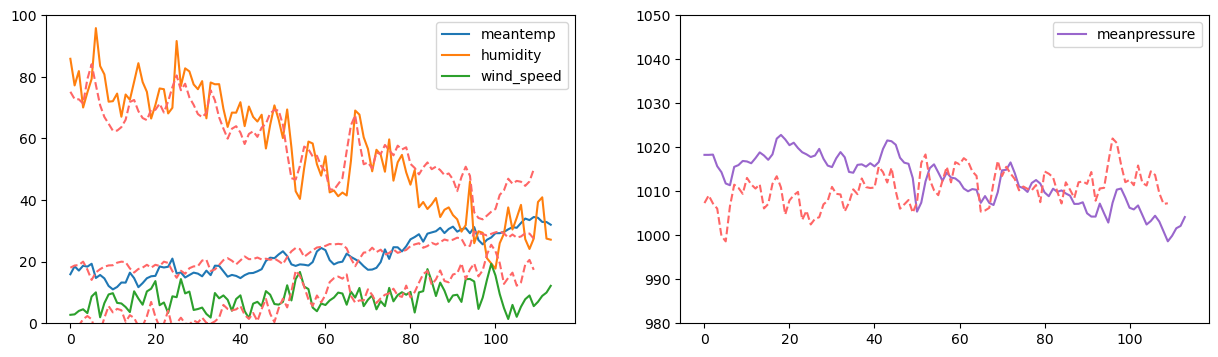

In [42]:
plt.figure(figsize=(15, 4))
plt.subplot(1,2,1)
plt.plot(test1, label="meantemp")
plt.plot(test2, label="humidity")
plt.plot(test3, label="wind_speed")

# plt.subplot(1,2,2)
plt.ylim(0, 100)
plt.plot(result1, color="#FF6666", linestyle="--")
plt.legend()

# plt.subplot(1,2,1)
plt.subplot(1,2,2)
plt.plot(test4, label="meanpressure", color="#9966CC")
plt.ylim(980, 1050)
plt.plot(result2, color="#FF6666", linestyle='--')

plt.legend()

In [33]:
qmodel = QModel(input_size, hidden_size, num_output, 
    num_layers = num_layers, ctx = ctx, mode='classical')

In [35]:
trainable = 0
for p in qmodel.parameters():
    if p.requires_grad:
        trainable += p.numel()
print(f'total parameters: {trainable}')

total parameters: 3364
